# Training Neural Networks

The network we built in the previous part isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

In [2]:
x = torch.randn(2,2, requires_grad=True) #2 x 2 행렬.
#requires_grad로 오토 그라디언트 사용 여부를 지정한다. 자동 미분
#requires_grad는 텐서의 연산(기울기 계산)을 추적한다. 계산 작업이 완료 되었다면, backward()로 그라디언트를 역방향으로 전달해 자동으로 계산한다.
#no_grad()로 오토 그라디언트 속성을 해제 할 수 있다. set_grad_enabled(True | False)로 켜고 끌 수 있다.
print(x)

#foward 함수만 정의하고 나면, 기울기(변화)를 계산하는 backward는 autograd로 자동 정의할 수 있다.
#https://9bow.github.io/PyTorch-tutorials-kr/beginner/blitz/autograd_tutorial.html#tensor

tensor([[ 0.9884, -0.7704],
        [-0.4261,  0.4691]])


In [3]:
y = x**2
print(y)

tensor([[ 0.9769,  0.5934],
        [ 0.1815,  0.2201]])


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [4]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)
#텐서는 Fuction을 참조하는 grad_fn 속성을 가지고 있다. (사용자가 직접 생성한 텐서는 기본으로 None 상태)
#여기서 y는 연산의 결과로 생성된 것이므로 grad_fn를 가지고 있다.

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [5]:
z = y.mean()
print(z)

#requires_grad는 이런 작업을 추적하고, 각 작업에 대한 그라디언트를 계산한다.

tensor(0.4930)


You can check the gradients for `x` and `y` but they are empty currently.

In [6]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [7]:
z.backward() #backward를 진행했으므로 grad가 생긴다.
print(x.grad) #x에 대한 z의 기울기 dz/dx
print(x/2)
#두 값이 같다.

tensor([[ 0.4942, -0.3852],
        [-0.2130,  0.2346]])
tensor([[ 0.4942, -0.3852],
        [-0.2130,  0.2346]])


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

## Get the data and define the network

The same as we saw in part 3, we'll load the MNIST dataset and define our network.

In [8]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [9]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [10]:
criterion = nn.CrossEntropyLoss() #손실 함수
optimizer = optim.SGD(model.parameters(), lr=0.01) #최적화 함수

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [11]:
# PyTorch의 일반적인 Deep Learning 프로세스
#1. 네트워크를 forawd해서 로짓을 얻는다.
#2. 로짓을 사용해 손실을 구한다.
#3. backward()함수를 사용해 backward를 진행해 그라디언트를 계산한다.
#4. 최적화 함수로 가중치를 업데이트 한다.

print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader)) #배치별로 iter
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad() #기울기가 누적되기 때문에 초기화 시켜줘야 한다.

# Forward pass, then backward pass, then update weights
output = model.forward(images) #forward
loss = criterion(output, labels) #손실함수에 로짓(forward의 output)과, 정답 레이블을 넣어 손실을 구한다.
loss.backward() #backward
print('Gradient -', model.fc1.weight.grad)
optimizer.step() #가중치 업데이트

Initial weights -  Parameter containing:
tensor([[ 1.0098e-02, -3.4799e-02,  7.4504e-03,  ...,  9.9423e-03,
          1.9646e-02,  3.4729e-03],
        [-2.2836e-03, -5.0188e-03,  3.0471e-02,  ..., -2.0746e-02,
          2.3190e-02, -1.0607e-02],
        [ 7.8642e-03, -2.4559e-02,  2.6093e-02,  ..., -1.0387e-02,
         -3.1774e-02, -2.0078e-02],
        ...,
        [ 2.1904e-02,  2.6433e-02, -1.6247e-02,  ..., -2.1297e-02,
         -2.1141e-02, -2.2152e-02],
        [ 2.5850e-02,  2.5035e-02,  2.9438e-02,  ...,  3.8800e-03,
         -3.2661e-03, -1.8360e-02],
        [-9.9867e-03,  2.2644e-02,  1.0550e-02,  ...,  1.3369e-02,
         -1.0737e-02,  3.5423e-02]])
Gradient - tensor(1.00000e-02 *
       [[ 0.0463,  0.0463,  0.0463,  ...,  0.0463,  0.0463,  0.0463],
        [-0.4169, -0.4169, -0.4169,  ..., -0.4169, -0.4169, -0.4169],
        [ 0.2397,  0.2397,  0.2397,  ...,  0.2397,  0.2397,  0.2397],
        ...,
        [ 0.1155,  0.1155,  0.1155,  ...,  0.1155,  0.1155,  0.1155],
  

In [12]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 1.0094e-02, -3.4804e-02,  7.4458e-03,  ...,  9.9376e-03,
          1.9642e-02,  3.4683e-03],
        [-2.2419e-03, -4.9771e-03,  3.0513e-02,  ..., -2.0705e-02,
          2.3232e-02, -1.0565e-02],
        [ 7.8402e-03, -2.4583e-02,  2.6069e-02,  ..., -1.0411e-02,
         -3.1798e-02, -2.0102e-02],
        ...,
        [ 2.1893e-02,  2.6421e-02, -1.6259e-02,  ..., -2.1309e-02,
         -2.1153e-02, -2.2163e-02],
        [ 2.5856e-02,  2.5040e-02,  2.9443e-02,  ...,  3.8854e-03,
         -3.2606e-03, -1.8354e-02],
        [-9.9846e-03,  2.2646e-02,  1.0552e-02,  ...,  1.3372e-02,
         -1.0735e-02,  3.5425e-02]])


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [14]:
#위에서 구현된 한 번의 학습을 여러번 반복하면 된다.

epochs = 3
print_every = 40
steps = 0
for e in range(epochs):
    running_loss = 0
    for images, labels in iter(trainloader): #배치별로 가져온다.
        steps += 1
        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad() #초기화
        
        # Forward and backward passes
        output = model.forward(images) #forward
        loss = criterion(output, labels) 
        loss.backward() #backward
        optimizer.step() #update
        
        running_loss += loss.item() #손실을 축적한다.
        
        if steps % print_every == 0: #40번 때 마다 출력
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0
            #40번 마다 누적된 손실의 평균을 출력하고, 0으로 초기화

Epoch: 1/3...  Loss: 2.2925
Epoch: 1/3...  Loss: 2.2787
Epoch: 1/3...  Loss: 2.2608
Epoch: 1/3...  Loss: 2.2480
Epoch: 1/3...  Loss: 2.2297
Epoch: 1/3...  Loss: 2.2075
Epoch: 1/3...  Loss: 2.1885
Epoch: 1/3...  Loss: 2.1609
Epoch: 1/3...  Loss: 2.1388
Epoch: 1/3...  Loss: 2.1062
Epoch: 1/3...  Loss: 2.0752
Epoch: 1/3...  Loss: 2.0266
Epoch: 1/3...  Loss: 1.9976
Epoch: 1/3...  Loss: 1.9326
Epoch: 1/3...  Loss: 1.8792
Epoch: 1/3...  Loss: 1.8309
Epoch: 1/3...  Loss: 1.7672
Epoch: 1/3...  Loss: 1.7129
Epoch: 1/3...  Loss: 1.6385
Epoch: 1/3...  Loss: 1.5601
Epoch: 1/3...  Loss: 1.4939
Epoch: 1/3...  Loss: 1.4178
Epoch: 1/3...  Loss: 1.3300
Epoch: 2/3...  Loss: 0.6988
Epoch: 2/3...  Loss: 1.2382
Epoch: 2/3...  Loss: 1.1602
Epoch: 2/3...  Loss: 1.0928
Epoch: 2/3...  Loss: 1.0588
Epoch: 2/3...  Loss: 1.0167
Epoch: 2/3...  Loss: 0.9510
Epoch: 2/3...  Loss: 0.9354
Epoch: 2/3...  Loss: 0.9058
Epoch: 2/3...  Loss: 0.8605
Epoch: 2/3...  Loss: 0.8264
Epoch: 2/3...  Loss: 0.7922
Epoch: 2/3...  Loss:

With the network trained, we can check out it's predictions.

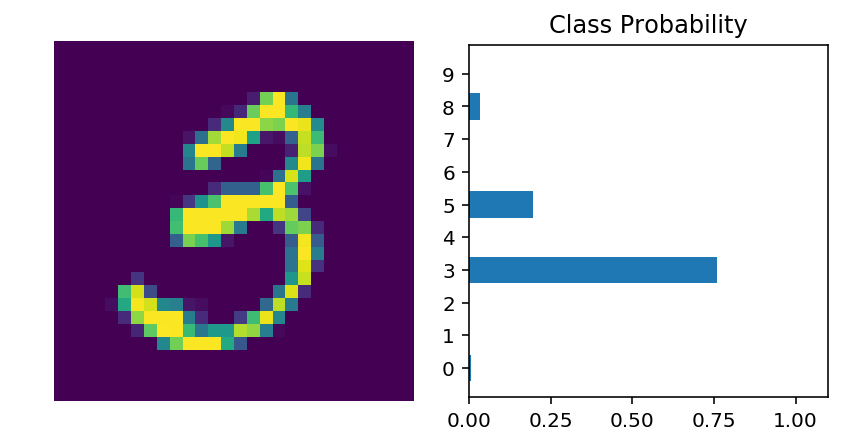

In [15]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)
#학습된 모델로 예측

Now our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset.